**高级自动微分**

自动微分指南包括了梯度计算的所有知识。本指南重点介绍tf.GradientTape 接口更深入，更罕见的功能。

**建立**

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)


**控制梯度记录**

在本指南中，你将学会在进行梯度计算时，如何控制tape所监视的变量和张量。
如果你想停止记录梯度的话，你可以用GradientTape.stop_recording() 去暂停记录。
如果你不想在模型中区分复杂的操作，这方法可能会帮到你。它还可以计算指标或中间结果：

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])


In [ ]:
dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None

如果你希望全部重新开始，请使用reset（）。通常，退出tape区域并重新开始会更容易阅读，但是当退出十分困难或根本不可能时，可以使用reset。

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])


In [ ]:
dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None

**停止梯度**

与上面对全局tape的控制不同，tf.stop_gradient函数要精确许多，它可阻止梯度沿特定的路径流动，而且无需访问tape本身：

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])


In [ ]:
dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


**自定义梯度**

在某些情况下，您可能需要精确控制梯度的计算方式，而不是使用默认值。这些情况包括：

*   你正在编写的新操作没有定义梯度。
*   默认计算在数值上不稳定。
*   你希望在向前传播的过程中缓存一个开销很大的计算。
*   你打算在不修改梯度的情况下修改某个值（例如使用：tf.clip_by_value, tf.math.round)。
对于编写新的操作，可以使用tf.RegisterGradient 建立。详见该页。（请注意梯度注册表是全局的，因此请小心更改。）
对于后三种情况，可以使用tf.custom_gradient.
下面的例子将tf.clip_by_norm应用到中间梯度：

In [ ]:
# 建立恒等操作，但在梯度传播的过程中裁剪
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # 调用backward方法，将4裁剪为2



In [ ]:
tf.Tensor(2.0, shape=(), dtype=float32)

详见见tf.custom_gradient以查看更多细节。

**多重tape**

多个tape可以相互交互，例如，这里每个tape监视不同的张量集：

In [ ]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)


In [ ]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

In [ ]:
1.0

In [ ]:
0.25

**高阶梯度**

为了达到自动区分的目的，我们可以记录GradientTape上下文管理器中的操作。如果在文中计算梯度，那么梯度的计算值也会被记录下来。因此，同样的接口也适用于高阶梯度。例如：

In [ ]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # 在外部的“t2”中计算渐变
  # 这意味着梯度计算也是可微的
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0


虽然这确实为你提供了标量函数的二阶导数，但是由于GradientTape.gradient仅计算标量的梯度，因此该模式不能推广生成海森矩阵。要构造海森矩阵，请参见“ 雅可比”部分下的海森矩阵示例 。 
在用梯度计算标量时，“嵌套着调用GradientTape.gradient ”是一个很好的方法，然后所得的标量将用作第二个梯度计算的源，如以下示例所示

**示例：输入梯度正则化**

许多模型容易受到“对抗性例子”的影响。这套技术修改了模型的输入，以打乱模型的输出。 最简单的方法是沿着输出相对于输入的梯度前进一步。
输入梯度正则化可提高对抗性示例鲁棒性 ，它试图使输入梯度最小化。如果输入梯度很小，那么输出的变化也应该很小。 
以下是输入梯度正则化的简单步骤。方法是： 

1.   使用内部的tape计算输出相对于输入的梯度。 
2.   计算该输入梯度的大小。 
3.   计算出相对于模型的梯度。 

In [ ]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)


In [ ]:
with tf.GradientTape() as t2:
  # 内部tape只考虑输入的梯度,
  # 而非变量.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. 计算输入梯度.
  g1 = t1.gradient(out, x)
  # 2. 计算输入梯度的大小.
  g1_mag = tf.norm(g1)

# 3. 计算相对于模型的梯度
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)


In [ ]:
[var.shape for var in dg1_mag]

In [ ]:
[TensorShape([5, 10]), TensorShape([10])]

**雅可比**

前面所有的例子都采用标量相对于某个源张量的梯度。雅可比矩阵表示向量值函数的梯度。每行包含一个向量元素的梯度。

GradientTape.jacobian方法可帮你高效地计算雅可比矩阵。

请注意：

*   像梯度一样： sources参数可以是张量或张量容器。 
*   与梯度不同： target张量必须是单个张量。

**标量源**

作为第一个例子，这是矢量-目标相对于标量-源的雅可比行列式。

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

当对标量取雅可比时，结果就是目标的形状，并给出每个元素相对于源的梯度：

In [ ]:
print(y.shape)
print(dy_dx.shape)

In [ ]:
(201,)
(201,)

In [ ]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

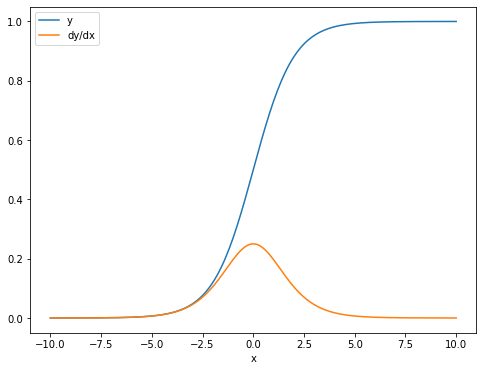

**张量源**

无论输入是标量还是张量， GradientTape.jacobian都能有效地计算源中每个元素相对于目标中每个元素的梯度。

例如，该层的输出的形状为(10,7)：

In [ ]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

In [ ]:
TensorShape([7, 10])

层的内核形状为(5,10)：

In [ ]:
layer.kernel.shape

In [ ]:
TensorShape([5, 10])

输出相对于内核的雅可比行列式的形状是这两个形状连接在一起后的形状：

In [ ]:
j = tape.jacobian(y, layer.kernel)
j.shape

In [ ]:
TensorShape([7, 10, 5, 10])

如果对目标维度进行求和，则和的梯度是可通过GradientTape.gradient计算得出的：

In [ ]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

In [ ]:
g.shape: (5, 10)
delta: 4.7683716e-07

**例子：海森矩阵**

尽管tf.GradientTape没有提供用于构造海森矩阵的显式方法，但可以使用GradientTape.jacobian方法来构建矩阵。

注意： 海森矩阵包含N**2参数。由于一些原因，对于大多数模型来说，这是不可能的。本例的更多内容是关于如何使用GradientTape.jacobian方法的说明，而不是对直接基于Hessian优化的解释。使用嵌套tape可有效地计算海森矩阵向量乘积，这个方法可有效的用于二阶优化。

In [ ]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [ ]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

In [ ]:
layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)

要将此海森矩阵用于牛顿方法，你首先需要将其轴展平为矩阵，然后将梯度展平为向量：

In [ ]:
n_params = tf.reduce_prod(layer1.kernel.shape)
g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

海森矩阵应该是对称的：

In [ ]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()


In [ ]:
imshow_zero_center(h_mat)

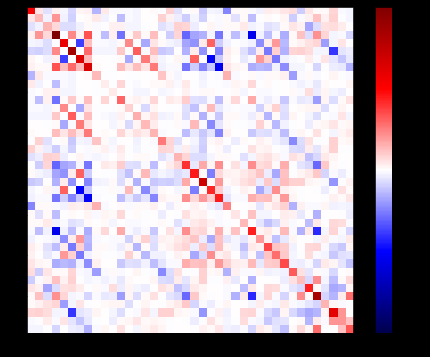

牛顿的方法更新步骤如下所示。

In [ ]:
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

注意： 不要转置矩阵 。

In [ ]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# 重塑更新并将其应用于变量。
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

尽管对于单个tf.Variable而言这相对简单，但将其应用于非平凡模型将需要仔细级联和切片，以在多个变量之间产生完整的海森矩阵。

**批量雅可比**

在某些情况下，你想要获取目标堆栈相对于源堆栈的雅可比行列式，其中每个目标-源堆栈对的雅可比行列式都是独立的。 

例如，此处输入x的形状为(batch, ins) ，而输出y形状为(batch, outs) 。

In [ ]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

In [ ]:
TensorShape([7, 6])

虽然您只想要（batch，ins，outs），可y相对于x的完整雅可比矩阵的形状是（batch，ins，batch，outs）。

In [ ]:
j = tape.jacobian(y, x)
j.shape

In [ ]:
TensorShape([7, 6, 7, 5])

如果堆栈中每个项的梯度都是独立的，则该张量的每个(batch, batch)切片都是对角矩阵：

In [ ]:
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

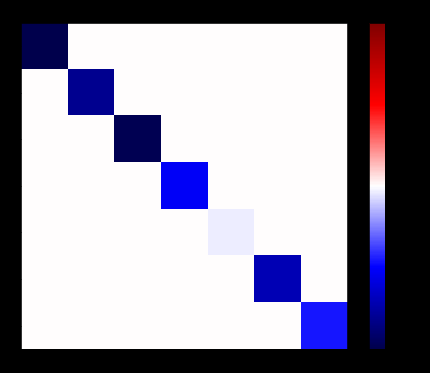

In [ ]:
def plot_as_patches(j):
  # 重新排列轴，使对角线每个都形成一个连续的面片。
  j = tf.transpose(j, [1, 0, 3, 2])
  # 在每个补丁之间填充。
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # R形成一个单一的形象.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')


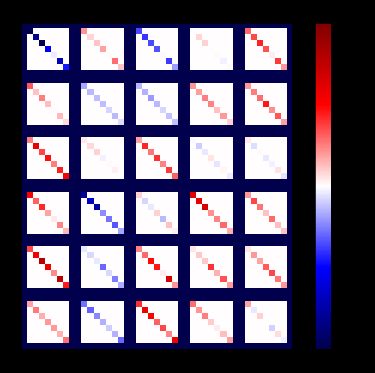

要获得所需的结果，可以对重复的批处理维度求和，或者使用tf.einsum选择对角线。

In [ ]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

In [ ]:
(7, 6, 5)
(7, 6, 5)

在没有额外维度的情况下进行计算会更加高效。 GradientTape.batch_jacobian方法可以做到这一点。

In [ ]:
jb = tape.batch_jacobian(y, x)
jb.shape

In [ ]:
TensorShape([7, 6, 5])

In [ ]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

In [ ]:
0.0

警告： GradientTape.batch_jacobian仅验证源和目标的第一个维度是否匹配。它不检查梯度是否是独立的。用户需要确保他们每次使用batch_jacobian都有意义。例如添加一个layers.BatchNormalization破坏了独立性，因为它跨批次维度进行了规范化：

In [ ]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')


In [ ]:
j.shape: (7, 6, 7, 5)

In [ ]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

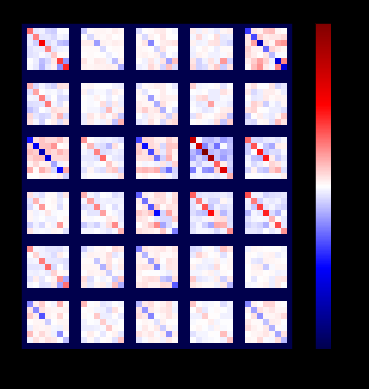

在本例中，batch_jacobian仍然可运行并返回具有预期形状的内容，但其内容的含义不明确。 

In [ ]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

In [ ]:
jb.shape: (7, 6, 5)